In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import time
import sys
import os
import networkx as nx

import seaborn as sns
import matplotlib.dates as mdates
from datetime import datetime, date

# preamble for jupyter notebook and django
import django
import platform

if platform.node() == "srv-mcc-apsis":
    sys.path.append("/home/muef/tmv/BasicBrowser/")
    #sys.path.append('/home/leey/tmv/BasicBrowser/')
    dtm_path = "/home/galm/software/dtm/dtm/main"
else:
    # local paths
    sys.path.append('/media/Data/MCC/tmv/BasicBrowser/')
    dtm_path = "/home/finn/dtm/dtm/main"

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

# import from appended path
import parliament.models as pm
import scoping.models as sm
from parliament.tasks import do_search, run_tm, combine_searches
import cities.models as cmodels
from django.contrib.auth.models import User
from tmv_app.models import * 
from utils.tm_mgmt import update_topic_scores
from django.db.models import Q, Count, Func, F, Sum, Avg, Value as V
from django.db.models.functions import TruncDate, TruncMonth, TruncYear

In [2]:
def get_graph(corr, threshold):
    adjacency_matrix = corr.ge(threshold).values - np.identity(corr.shape[0])
    G = nx.from_numpy_array(adjacency_matrix)
    print(nx.info(G))
    
    topic_ids = list(corr.index)

    labels = {}
    top_words = {}
    for i, topic_id in enumerate(topic_ids):
        topic = Topic.objects.get(id=topic_id)
        labels[i] = topic.title
        top_words[i] = ", ".join(topic.top_words)
        
    nx.set_node_attributes(G, labels, name="label")
    nx.set_node_attributes(G, top_words, name="topwords")

    return G


def show_graph(G):
    
    #pos=nx.circular_layout(G)
    pos=nx.spring_layout(G)

    #nx.draw_networkx_edges(G, pos)
    #nx.draw_networkx_nodes(G, pos, )

    nx.draw(G, pos, node_color='#A0CBE2',
            width=2, edge_cmap=plt.cm.Blues, with_labels=False)

    nx.draw_networkx_labels(G,pos,nx.get_node_attributes(G,"label"),font_size=8)

    plt.show()
    
def corr_hist(corr, threshold_pct):
    vals = (corr.values - np.identity(corr.shape[0])).flatten()
    print(np.percentile(vals, threshold_pct))
    plt.hist(vals, bins=50)

In [3]:
def print_network_characteristics(graph):
# print basic characteristics of the filtered graph
    print("nodes: {}".format(graph.number_of_nodes()))
    print("links: {}".format(graph.number_of_edges()))
    print("directed: {}".format(graph.is_directed()))
    print("link density: {}".format(nx.density(graph)))

    

# functions to compute and visualize network measures
def compute_network_measures(G, all_global_measures=True, centrality_measures=False,
                             write_output_file=None, verbosity=1):

    print("computing network measures...")
    no_nodes = G.number_of_nodes()
    no_edges = G.number_of_edges()
    link_density = no_edges / no_nodes
    nx.set_node_attributes(G, dict(nx.degree(G)), 'degree')
    mean_degree = np.mean(list(nx.get_node_attributes(G, 'degree').values()))

    ccs = nx.clustering(G)
    mean_clustering_coefficient = sum(list(ccs.values())) / no_nodes

    list_cc = [len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
    nodes_in_largest_component = list_cc[0]
    # make copy to separate largest component of the graph
    G_p = G.copy()
    largest_component = sorted(nx.connected_components(G_p),
                               key=len, reverse=True)[0]
    node_list_old = list(G_p.nodes())
    for node in node_list_old:
        if not (node in largest_component):
            G_p.remove_node(node)

    if all_global_measures:
        print("calculating diameter...")
        diameter_largest_component = nx.diameter(G_p)
        print("calculating radius...")
        radius_largest_component = nx.radius(G_p)

    if centrality_measures:
        print("calculating betweenness centrality...")
        # betweenness centrality
        bnc = nx.betweenness_centrality(G_p)
        assert isinstance(bnc, dict)
        nx.set_node_attributes(G, bnc, 'betweennessc_largest_component')
        mean_betweennessc_largest_component = np.mean(list(bnc.values()))

        print("calculating eigenvector centrality...")
        # eigenvector centrality
        evc = nx.eigenvector_centrality(G_p)
        assert isinstance(evc, dict)
        nx.set_node_attributes(G, evc, 'eigenvectorc_largest_component')
        mean_eigenvectorc_largest_component = np.mean(list(evc.values()))

        print("calculating closeness centrality...")
        # closeness centrality
        clc = nx.closeness_centrality(G_p)
        assert isinstance(clc, dict)
        nx.set_node_attributes(G, clc, 'closenessc_largest_component')
        mean_closenessc_largest_component = np.mean(list(clc.values()))

    if verbosity > 0:
        print("Number of nodes: " + str(no_nodes))
        print("Number of edges: " + str(no_edges))
        print("Link density: " + str(link_density))
        print("Mean degree: " + str(mean_degree))
        print("Mean clustering coefficient: " + str(mean_clustering_coefficient))
        print("Connected components:", list_cc)

        if all_global_measures:
            print("Diameter of largest component: " + str(diameter_largest_component))
            print("Radius of largest component: " + str(radius_largest_component))

        if centrality_measures:
            print("Mean betweenness centrality (of largest component): "
                  + str(mean_betweennessc_largest_component))

            print("Mean eigenvector centrality (of largest component): "
                  + str(mean_eigenvectorc_largest_component))

            print("Mean closeness centrality (of largest component) "
                  + str(mean_closenessc_largest_component))

    if write_output_file:
        f = open(write_output_file, "w")
        f.write("Network measures for spatial graph\n")
        f.write("\nNumber of nodes: " + str(no_nodes))
        f.write("\nNumber of edges: " + str(no_edges))
        f.write("\nLink density: " + str(link_density))
        f.write("\nMean degree: " + str(mean_degree))
        f.write("\nMean clustering coefficient: " + str(mean_clustering_coefficient))
        f.write("\nConnected components: " + str(list_cc))

        if all_global_measures:
            f.write("\nDiameter of largest component: " + str(diameter_largest_component))
            f.write("\nRadius of largest component: " + str(radius_largest_component))

        if centrality_measures:
            f.write("\nMean betweenness centrality (of largest component): "
                    + str(mean_betweennessc_largest_component))

            f.write("\nMean eigenvector centrality (of largest component): "
                    + str(mean_eigenvectorc_largest_component))

            f.write("\nMean closeness centrality (of largest component) "
                    + str(mean_closenessc_largest_component))

        f.close()

    return 0


def plot_network_centrality_histograms(G, figure_file_path, log=False, normalized=True, no_bins=50):

    if 'betweennessc_largest_component' not in G.node[1]:
        compute_network_measures(G, centrality_measures=True, all_global_measures=False, verbosity=0)

    fig, ax = plt.subplots(4, figsize=(6, 8))

    degrees = dict(nx.get_node_attributes(G, 'degree'))
    # show degree distribution
    ax[0].hist(list(degrees.values()), bins=no_bins, normed=normalized)
    ax[0].set_title("degree histogram")

    betweennessc = dict(nx.get_node_attributes(G, 'betweennessc_largest_component'))
    ax[1].hist(list(betweennessc.values()), bins=no_bins, normed=normalized)
    ax[1].set_title("betweenness centrality histrogram")

    eigenvectorc = dict(nx.get_node_attributes(G, 'eigenvectorc_largest_component'))
    ax[2].hist(list(eigenvectorc.values()), bins=no_bins, normed=normalized)
    ax[2].set_title("eigenvector centrality histogram")

    closenessc = dict(nx.get_node_attributes(G, 'eigenvectorc_largest_component'))
    ax[3].hist(list(closenessc.values()), bins=no_bins, normed=normalized)
    ax[3].set_title("closeness centrality histrogram")

    if log:
        for axis in ax:
            axis.set_yscale('log', nonposy='clip')

    plt.tight_layout()
    fig.savefig(figure_file_path)
    print("saved figure to " + figure_file_path)

applying filter: {'0': True, '1': True, '2': True, '3': True, '4': True, '5': True, '6': True, '7': True, '8': True, '9': True, '12': True, '13': True, '14': True, '15': True, '16': True, '17': True, '19': True, '20': True, '21': True, '22': True, '24': True, '25': True, '27': True, '28': True, '29': True, '30': True, '31': True, '32': True, '33': True, '34': True, '35': True, '36': True, '37': True, '38': True, '39': True, '40': True, '41': True, '42': True, '43': True}
applying filter: {'0': True, '1': True, '2': True, '3': True, '4': True, '5': True, '6': True, '7': True, '8': True, '9': True, '12': True, '13': True, '14': True, '15': True, '16': True, '17': True, '19': True, '20': True, '21': True, '22': True, '24': True, '25': True, '27': True, '28': True, '29': True, '30': True, '31': True, '32': True, '33': True, '34': True, '35': True, '36': True, '37': True, '38': True, '39': True, '40': True, '41': True, '42': True, '43': True}
applying filter: {'0': True, '1': True, '2': Tru

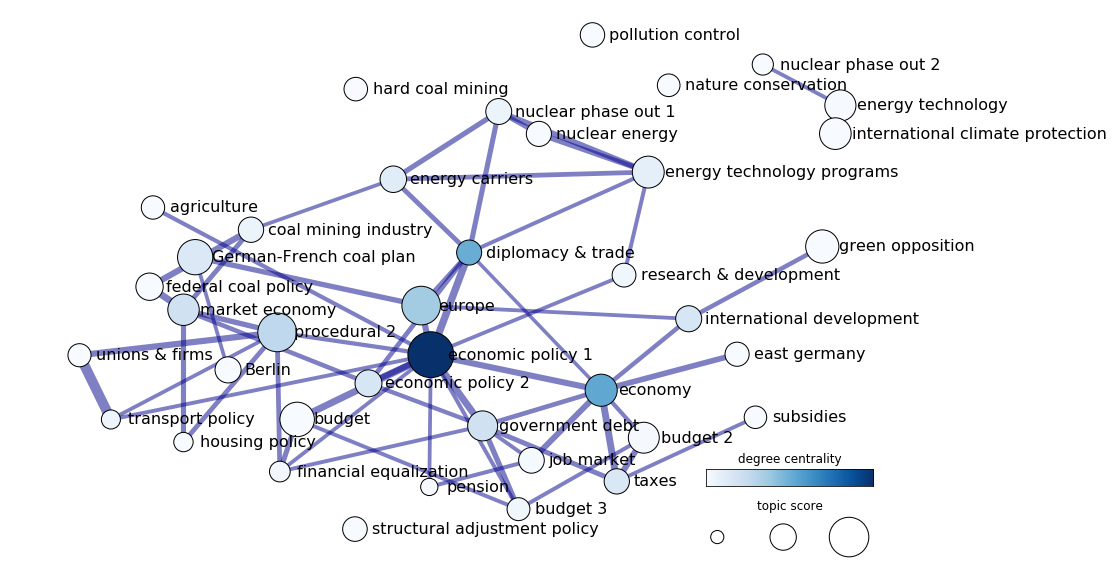

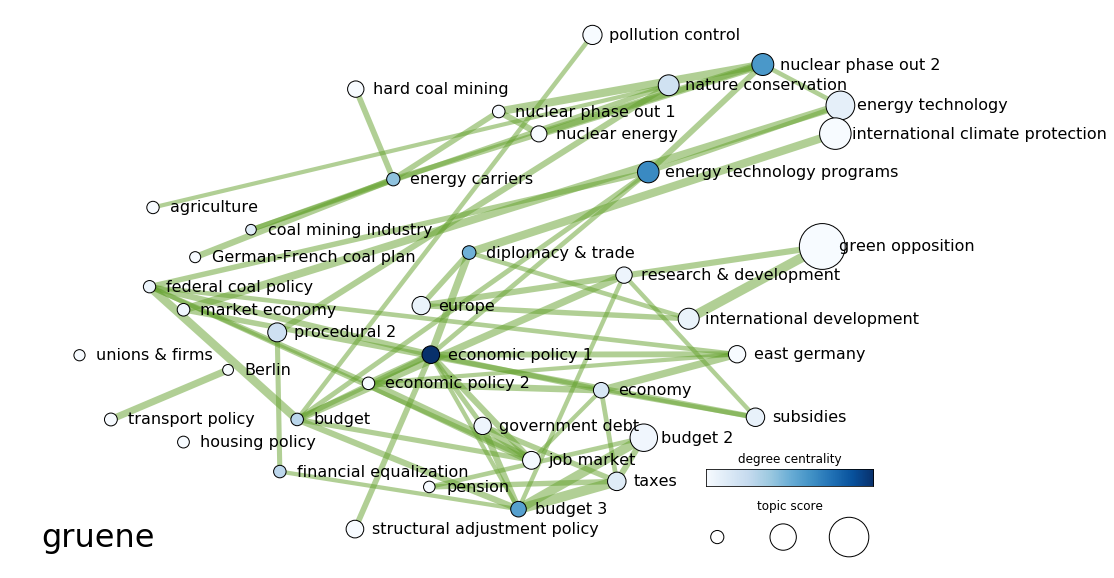

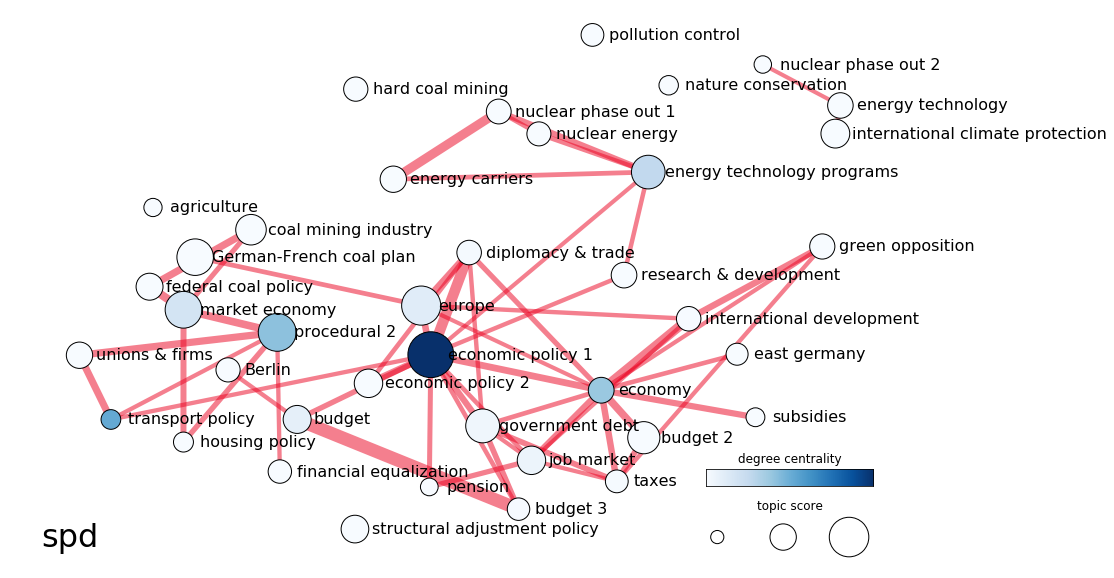

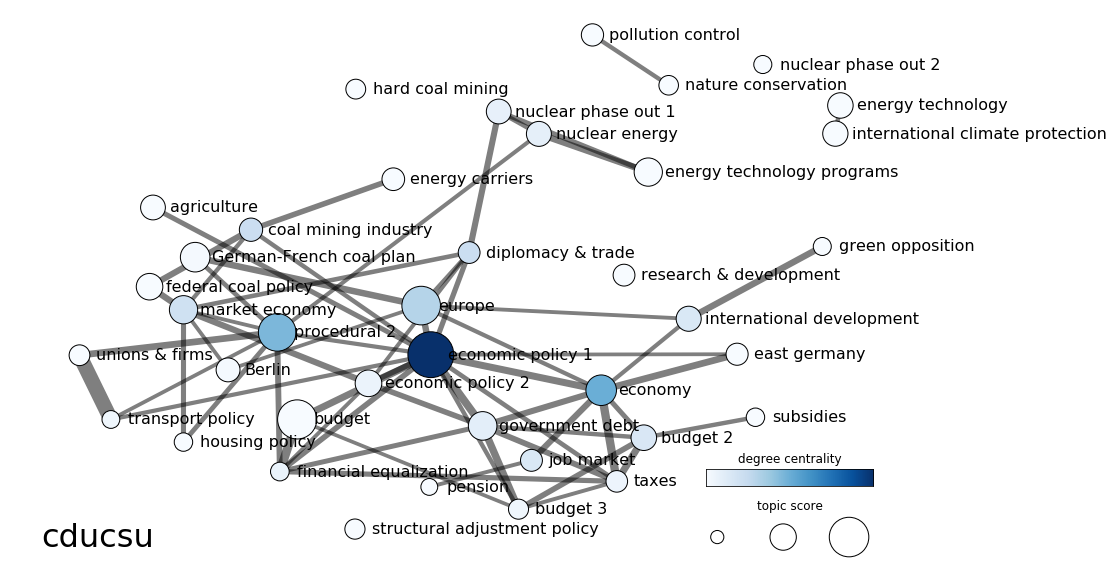

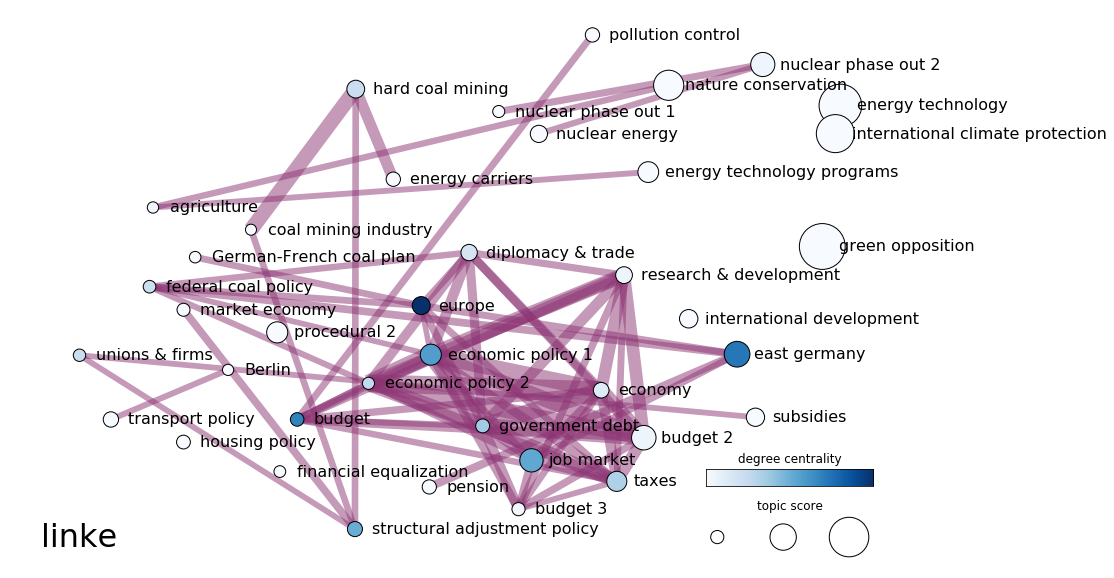

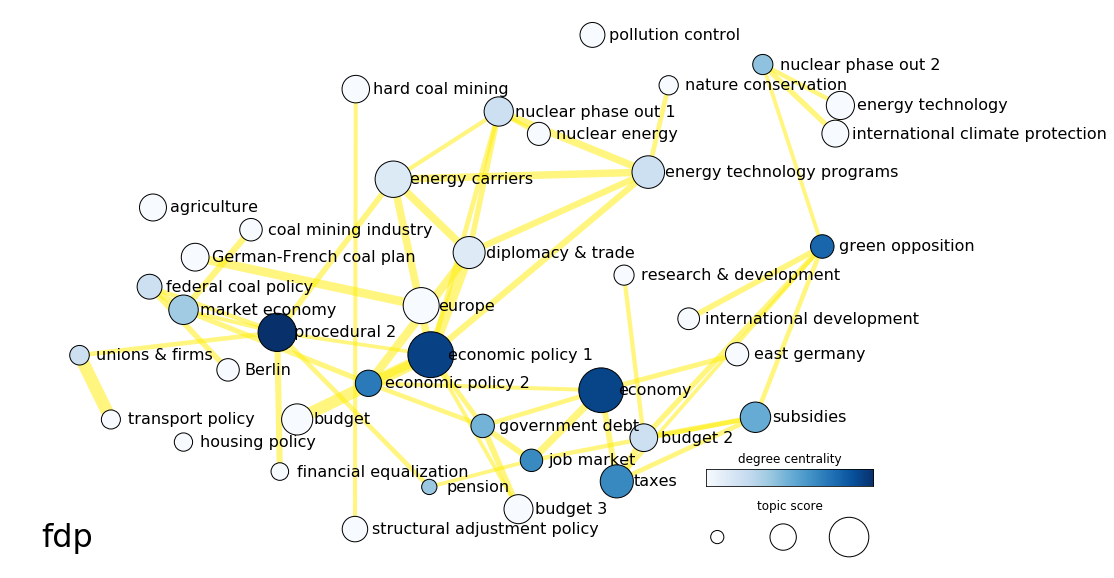

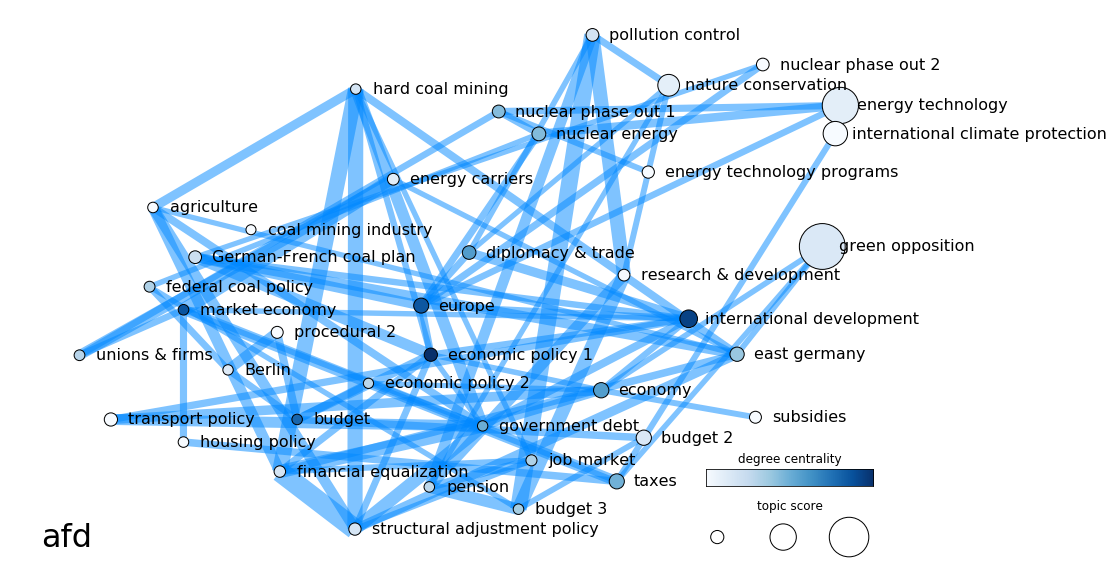

In [11]:
# todo: separate graph setup and plotting

# combine information

run_id = 2155

save_dir = "./topic_correlations/{}".format(run_id)

# to use this option, load exported graph file in gephi,
# run positioning algorith (e.g. Force Atlas 2 + Label Adjustment)
# and export as gephi_all_pos.graphml
pos_from_gephi = True
# to use this option add a new boolean attribute to the graph called "filter"
filter_nodes = True

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Circle

if pos_from_gephi:
    G_pos = nx.read_graphml(os.path.join(save_dir, 'gephi_all_pos.graphml'))

edge_color_dict = {"gruene": "#64A12D", "spd": "#EB001F", "cducsu": "#000000",
                   "linke": "#8C3473", "fdp": "#FFED00", "afd": "#0088FF", None: '#00008b' }

#edge_color_dict = '#8b0000'

party_iter = True
pp_iter = False

if party_iter:
    party_list = [None, "gruene", "spd", "cducsu", "linke", "fdp", "afd"]
else:
    party_list = [None]

if pp_iter:
    pp_list = ['1']#[str(i) for i in range(1,20)]
else:
    pp_list = [None]

for party_name in party_list:
    
    for pp in pp_list: #:

        if pp:
            graph_file = os.path.join(save_dir, 'topic_correlations_run{}_period_{}.graphml'.format(run_id, pp))

        else:
            graph_file = os.path.join(save_dir, 'topic_correlations_run{}_party_{}.graphml'.format(run_id, party_name))
        
        G_party = nx.read_graphml(graph_file)

        if pos_from_gephi:
            x = nx.get_node_attributes(G_pos, 'x')
            y = nx.get_node_attributes(G_pos, 'y')

            nx.set_node_attributes(G_party, x, 'x')
            nx.set_node_attributes(G_party, y, 'y')

        if filter_nodes:
            f = nx.get_node_attributes(G_pos, 'filter')
            nx.set_node_attributes(G_party, f, 'filter')
            
            print("applying filter: {}".format(f))

            nodes = list(G_party.nodes())
            for node in nodes:
                if not node in f.keys():
                    G_party.remove_node(node)

        #if pos_from_gephi or filter_nodes:
        #    nx.write_graphml(G_party, graph_file)

        # remove disconnected nodes
        #G_party.remove_node('15')

        fig, ax = plt.subplots(1, 1, figsize=(15, 10))

        if pos_from_gephi:
            pos = {node: [x[node], y[node]] for node in x.keys()}
        else:
            pos=nx.spring_layout(G_party)
            x = {}
            y = {}

            for key, value in pos.items():
                x[key] = value[0]
                y[key] = value[1]

        scores = nx.get_node_attributes(G_party, "totalscores")
        max_score = max(list(scores.values()))

        node_size = [100. + 2000.*scores[node]/max_score for node in G_party.nodes()]

        #node_color = list(nx.degree_centrality(G_party).values())
        node_color = list(nx.betweenness_centrality(G_party).values())
        #node_color = list(nx.eigenvector_centrality(G_party).values())

        cmap_name = 'Blues'

        nx.draw_networkx_nodes(G_party, pos, node_size=node_size,
                               node_color=node_color, #node_color='#A0CBE2',
                               alpha=1, # alpha of node colors
                               linewidths=1, edgecolors='k', # width and color of node edges
                               cmap=plt.get_cmap(cmap_name), #vmax=2100., vmin=0,
                               with_labels=False)
        edge_width = 1. + 20*np.array(list(nx.get_edge_attributes(G_party, "weight").values()))

        nx.draw_networkx_edges(G_party, pos, width=edge_width, alpha = 0.5, edge_color=edge_color_dict[party_name])
        #nx.draw_networkx_edges(G_party, pos, width=2., edge_color=edge_width, edge_cmap=plt.get_cmap('Greens'))

        labels = nx.get_node_attributes(G_party,"label")
        # central alignment of labels
        #nx.draw_networkx_labels(G_party,pos, labels,font_size=16)

        #ax.set_xlim([-720, 900])

        for i, node in enumerate(G_party.nodes()):
            distance_scale = 0.02 * (ax.get_xlim()[1] - ax.get_xlim()[0])
            # left alignment of labels
            ax.text(x[node] + distance_scale, #+ 0.02*node_size[i],
                    y[node], labels[node], verticalalignment='center', fontsize=16)
            #ax.text(x[node], y[node] - 10. - 0.02*node_size[i], labels[node],
                    #verticalalignment='top', horizontalalignment='center', fontsize=16)


        if party_name:
            ax.text(0, 0, party_name,
                horizontalalignment='left',
                verticalalignment='bottom',
                transform=ax.transAxes,
                fontsize=32)
        if pp:
            ax.text(0, 0, str(pp),
                horizontalalignment='left',
                verticalalignment='bottom',
                transform=ax.transAxes,
                fontsize=32)
        plt.axis('off')

        cmap = plt.cm.get_cmap(cmap_name)
        colors = cmap(np.arange(cmap.N))

        # inset for colormap
        axinset = inset_axes(ax, width="100%", height="100%",
                        bbox_to_anchor=(.8, .1, .2, .1),
                        bbox_transform=ax.transAxes)
        axinset.set_xticks([])
        axinset.set_yticks([])
        axinset.imshow([colors], extent=[0, 10, 0, 1])
        axinset.set_title('degree centrality')

        # inset for node size
        #axinset = inset_axes(ax, width="30%", height="20%", loc=4)
        axinset = inset_axes(ax, width="100%", height="100%",
                        bbox_to_anchor=(.8, .0, .2, .08),
                        bbox_transform=ax.transAxes)
        axinset.set_xticks([])
        axinset.set_yticks([])
        axinset.set_title('topic score')
        for i in range(1, 4):
            c = Circle([i, 0], radius=i*0.1, facecolor='w', edgecolor='k')
            axinset.add_patch(c)
        plt.axis('off')
        plt.axis('equal')

        #print_network_characteristics(G_party)
        #compute_network_measures(G_party)

        if party_iter:
            fig.savefig(os.path.join(save_dir, "graph_run_{}_party_{}".format(run_id, party_name)), dpi=300, bbox_inches='tight')
        else:
            fig.savefig(os.path.join(save_dir, "graph_run_{}_period_{}".format(run_id, pp)), dpi=300, bbox_inches='tight')

In [60]:
list(G_party.nodes(data=True))

[('0',
  {'label': 'targets',
   'id': 167068,
   'totalscores': 64741.0559964011,
   'x': 340.13156,
   'y': -154.89975,
   'filter': True}),
 ('1',
  {'label': 'energy transition 3',
   'id': 167069,
   'totalscores': 31822.5024771111,
   'x': 614.0471,
   'y': 8.152821,
   'filter': True}),
 ('2',
  {'label': 'power grid',
   'id': 167070,
   'totalscores': 8699.83845377911,
   'x': 760.18134,
   'y': -107.84953,
   'filter': True}),
 ('4',
  {'label': 'electricity market',
   'id': 167072,
   'totalscores': 53139.6891835649,
   'x': 511.7211,
   'y': -84.4362,
   'filter': True}),
 ('5',
  {'label': 'development',
   'id': 167073,
   'totalscores': 26617.8610989736,
   'x': 191.58739,
   'y': -6.3077006,
   'filter': True}),
 ('6',
  {'label': 'budget 2',
   'id': 167074,
   'totalscores': 32395.8654281876,
   'x': -400.9076,
   'y': -96.723404,
   'filter': True}),
 ('7',
  {'label': 'energy transition 2',
   'id': 167075,
   'totalscores': 24574.0743203876,
   'x': 670.5513,
   '

In [39]:
list(G_party.edges(data=True))

[('0', '1', {'weight': 0.09059694562729112}),
 ('0', '2', {'weight': 0.03824265214721995}),
 ('0', '4', {'weight': 0.1875740404272071}),
 ('0', '5', {'weight': 0.24602299382328166}),
 ('0', '7', {'weight': 0.13959312221341996}),
 ('0', '8', {'weight': 0.10283736560273195}),
 ('0', '9', {'weight': 0.018279940258613677}),
 ('0', '10', {'weight': 0.09819320173239772}),
 ('0', '21', {'weight': 0.15081923400844918}),
 ('0', '27', {'weight': 0.1787474795630834}),
 ('1', '2', {'weight': 0.09539374038861315}),
 ('1', '3', {'weight': 0.018318884333868284}),
 ('1', '4', {'weight': 0.03441320740950904}),
 ('1', '7', {'weight': 0.16863360940271777}),
 ('1', '21', {'weight': 0.027540553635695176}),
 ('1', '27', {'weight': 0.03808166867549244}),
 ('2', '3', {'weight': 0.009442260442282021}),
 ('2', '4', {'weight': 0.13821844671585598}),
 ('2', '7', {'weight': 0.16351846566753006}),
 ('2', '10', {'weight': 0.28338853215028303}),
 ('2', '12', {'weight': 0.027366212157808958}),
 ('2', '21', {'weight': 

In [1]:
%%bash
zip -r topic_correlations/2155.zip topic_correlations/2155/

updating: topic_correlations/2155/ (stored 0%)
updating: topic_correlations/2155/topic_correlations_run2155_period_1.graphml (deflated 79%)
updating: topic_correlations/2155/topic_correlations_run2155_party_gruene.graphml (deflated 79%)
updating: topic_correlations/2155/topic_correlations_run2155_period_9.graphml (deflated 79%)
updating: topic_correlations/2155/topic_correlations_run2155_period_6.graphml (deflated 79%)
updating: topic_correlations/2155/topic_correlations_run2155_period_7.graphml (deflated 79%)
updating: topic_correlations/2155/topic_correlations_run2155_period_16.graphml (deflated 79%)
updating: topic_correlations/2155/topic_correlations_run2155_period_15.graphml (deflated 79%)
updating: topic_correlations/2155/topic_correlations_run2155_party_fdp.graphml (deflated 79%)
updating: topic_correlations/2155/topic_correlations_run2155_period_2.graphml (deflated 79%)
updating: topic_correlations/2155/topic_correlations_run2155_period_10.graphml (deflated 79%)
updating: topic